In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

Attention: Ne pas oublier de changer le chemin vers les fichier ``train.csv``et ``test.csv``

In [2]:
# Load dataset
df = pd.read_csv("train.csv") # Change data path
X = df.drop('Cover_Type', axis=1)  # Explanatory variables (features)
Y = df['Cover_Type']               # Target variable

test = pd.read_csv("test.csv") # Change data path

## Exploratory Data Analysis

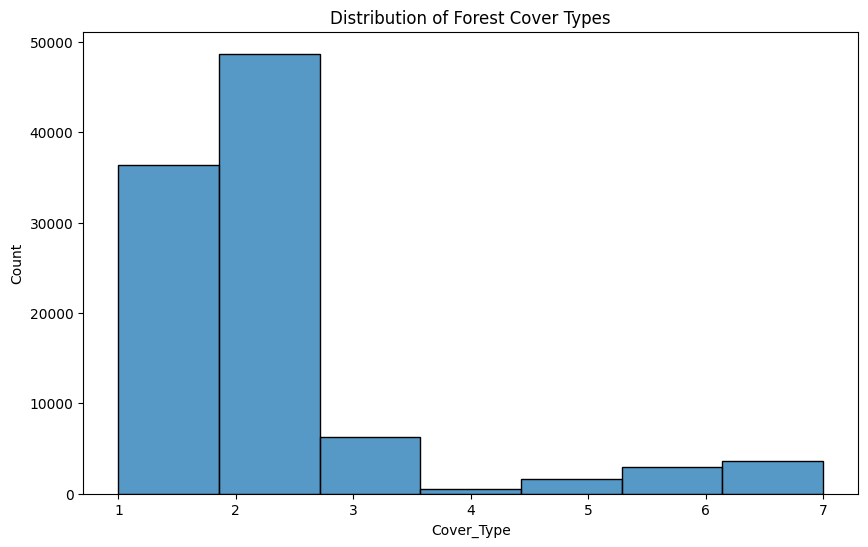

In [3]:
# Plot distributions and correlations of key variables
plt.figure(figsize=(10, 6))
sns.histplot(Y, kde=False, bins=7)  
plt.title("Distribution of Forest Cover Types")
plt.show()

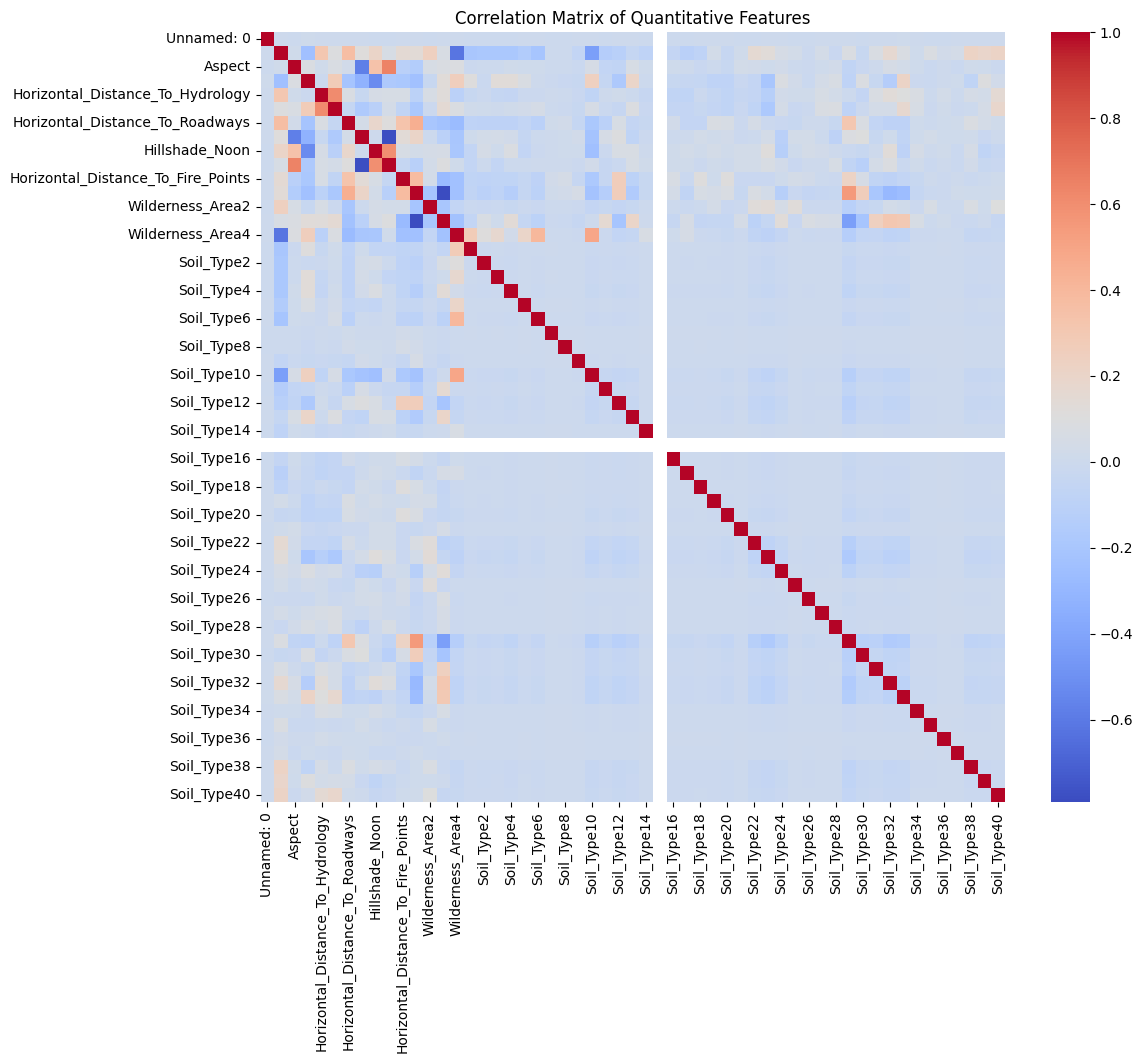

In [5]:
# Correlation matrix for quantitative features
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Quantitative Features")
plt.show()

## Data Preprocessing

In [6]:
# Drop unnecessary columns
X = X.drop(columns=['Unnamed: 0'], errors='ignore')
test = test.drop(columns=['Unnamed: 0'], errors='ignore')

In [7]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [8]:
# Scale features (StandardScaler for normalization)
scaler = StandardScaler()
X_train_normed = scaler.fit_transform(X_train)
X_test_normed = scaler.transform(X_test)
test_normed = scaler.transform(test.drop(columns=['row_ID'], errors='ignore'))

## Model Selection and Hyperparameter Tuning

In [2]:
# Define parameter grids for each model
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    }
}

In [17]:
# Models initialization
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0),
    'LogisticRegression': LogisticRegression(random_state=0)
}

In [ ]:
# Function to train and evaluate a model
def train_and_eval(model, param_grid):
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                               scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_normed, Y_train)
    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    
    # Predictions and Evaluation
    Y_train_pred = best_model.predict(X_train_normed)
    Y_test_pred = best_model.predict(X_test_normed)
    
    # Model Evaluation Metrics
    print(f"Training F1 Score: {f1_score(Y_train, Y_train_pred, average='weighted')}")
    print(f"Testing F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted')}")
    print("Classification Report:\n", classification_report(Y_test, Y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_test_pred))

    # Cross-validation score for robustness
    cv_score = cross_val_score(best_model, X_train_normed, Y_train, cv=5, scoring='f1_weighted', n_jobs=-1).mean()
    print(f"Cross-Validation F1 Score: {cv_score}")

    # Final Predictions on Test Set
    predictions = best_model.predict(test_normed)
    if 'row_ID' in test.columns:
        predictions_df = pd.DataFrame({
            "row_ID": test["row_ID"],
            "Prediction": predictions
        })
    else:
        predictions_df = pd.DataFrame({"Prediction": predictions})

    # Save predictions
    output_file = f"{model.__class__.__name__}_predictions.csv"
    predictions_df.to_csv(output_file, index=False)
    
    return best_model, cv_score

In [18]:
# Function to train and evaluate each model
def train_and_eval_all(models, param_grids):
    results = []
    for model_name, model in models.items():
        print(f"\nTraining and evaluating {model_name}...")
        param_grid = param_grids[model_name]
        best_model, cv_score = train_and_eval(model, param_grid)  # Use the train_and_eval function from previous code
        results.append((model_name, best_model, cv_score))
    return results


Training and evaluating RandomForestClassifier...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training F1 Score: 1.0
Testing F1 Score: 0.9011716583995278
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.88      0.90      9173
           2       0.89      0.94      0.92     12260
           3       0.87      0.92      0.90      1484
           4       0.81      0.68      0.74        95
           5       0.90      0.54      0.67       420
           6       0.89      0.73      0.80       676
           7       0.95      0.88      0.92       892

    accuracy                           0.90     25000
   macro avg       0.89      0.80      0.84     25000
weighted avg       0.90      0.90      0.90     25000

Confusion Matrix:
 [[ 8076  1056     0     0     2     2    37]
 [  630 115

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best Parameters for LogisticRegression: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
Training F1 Score: 0.7163817951131226
Testing F1 Score: 0.7191014295736432
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.71      0.71      9173
           2       0.75      0.80      0.78     12260
           3       0.69      0.79      0.74      1484
           4       0.64      0.46      0.54        95
           5       0.27      0.01      0.01       420
           6       0.48      0.27      0.34       676
           7       0.71      0.57      0.63       892

    accuracy                           0.73     25000
   macro avg       0.61      0.52      0.54     25000
weighted avg       0.72      0.73      0.72     25000

Confusion Matrix:
 [[6474 2497    1    0    1    5  195]
 [2221 9827  134    1    7   62    8]
 [   0  168 1176   21    0  119    0]
 [   0    0   36   44    0   15    0]
 [   2  398   17    0    3    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-Validation F1 Score: 0.7152030775989193


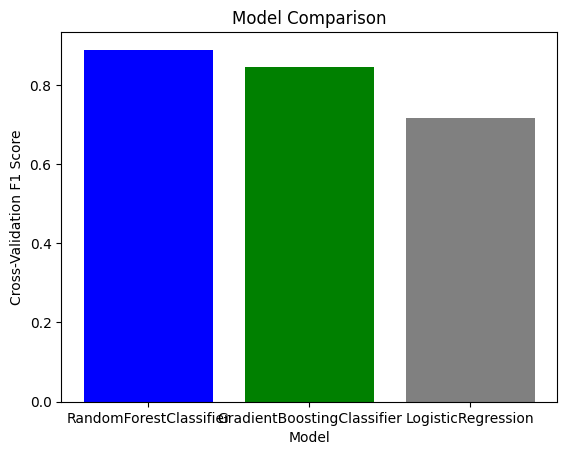

In [19]:
# Train and evaluate all models
results = train_and_eval_all(models, param_grids)

# Final comparison plot
model_names, _, cv_scores = zip(*results)
plt.bar(model_names, cv_scores, color=['blue', 'green', 'gray'])
plt.xlabel('Model')
plt.ylabel('Cross-Validation F1 Score')
plt.title('Model Comparison')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest Classification Report:

              precision    recall  f1-score      support
1              0.918508  0.883888  0.900865   7243.00000
2              0.896913  0.941896  0.918854   9810.00000
3              0.865297  0.919159  0.891415   1237.00000
4              0.806452  0.649351  0.719424     77.00000
5              0.871795  0.513595  0.646388    331.00000
6              0.876190  0.743134  0.804196    619.00000
7              0.946203  0.875549  0.909506    683.00000
accuracy       0.902850  0.902850  0.902850      0.90285
macro avg      0.883051  0.789510  0.827236  20000.00000
weighted avg   0.903056  0.902850  0.901498  20000.00000


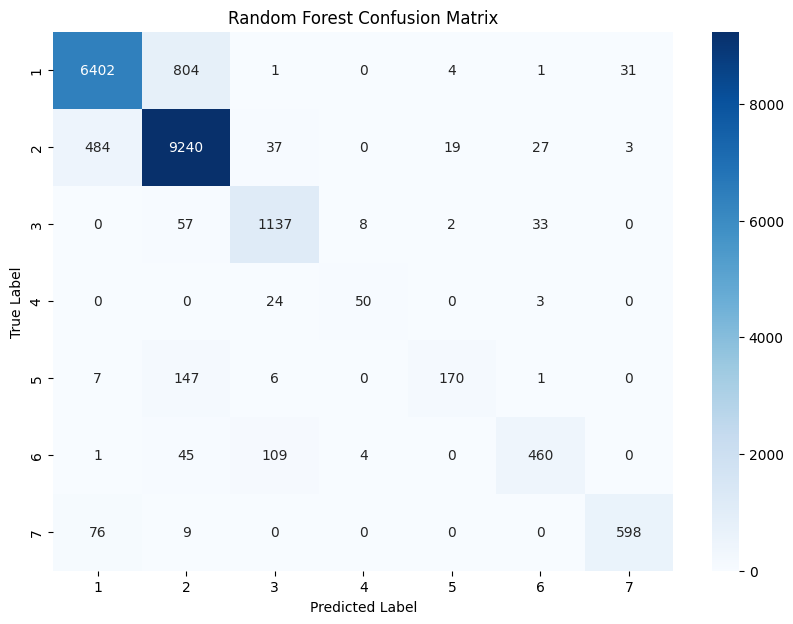



Gradient Boosting Classification Report:

              precision    recall  f1-score      support
1              0.853947  0.827420  0.840474   7243.00000
2              0.854739  0.890724  0.872361   9810.00000
3              0.860789  0.899757  0.879842   1237.00000
4              0.787879  0.675325  0.727273     77.00000
5              0.766990  0.477341  0.588454    331.00000
6              0.817029  0.728595  0.770282    619.00000
7              0.915888  0.860908  0.887547    683.00000
accuracy       0.854650  0.854650  0.854650      0.85465
macro avg      0.836752  0.765724  0.795176  20000.00000
weighted avg   0.854038  0.854650  0.853378  20000.00000


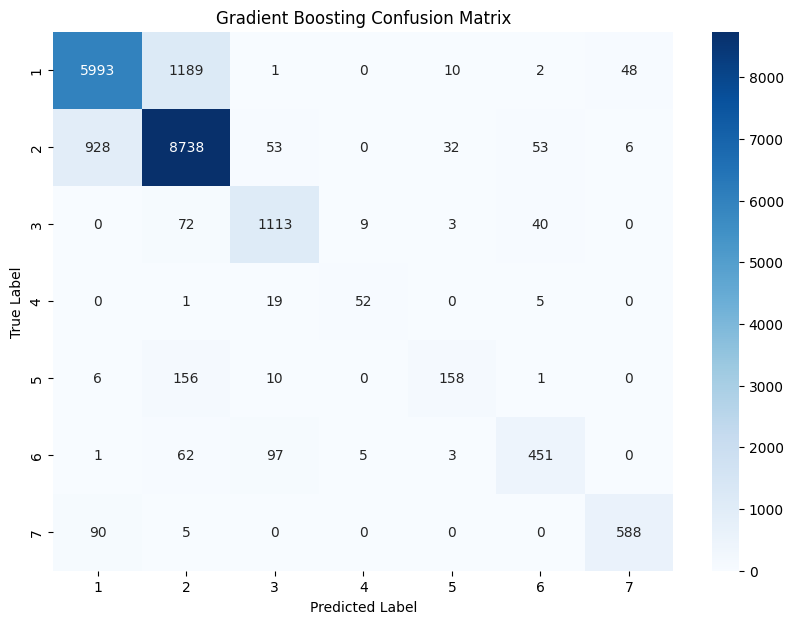



Logistic Regression Classification Report:

              precision    recall  f1-score     support
1              0.641837  0.632887  0.637331   7243.0000
2              0.665833  0.787258  0.721472   9810.0000
3              0.575655  0.550525  0.562810   1237.0000
4              0.000000  0.000000  0.000000     77.0000
5              0.000000  0.000000  0.000000    331.0000
6              0.125000  0.006462  0.012289    619.0000
7              0.272727  0.017570  0.033012    683.0000
accuracy       0.650200  0.650200  0.650200      0.6502
macro avg      0.325865  0.284957  0.280988  20000.0000
weighted avg   0.607819  0.650200  0.621009  20000.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

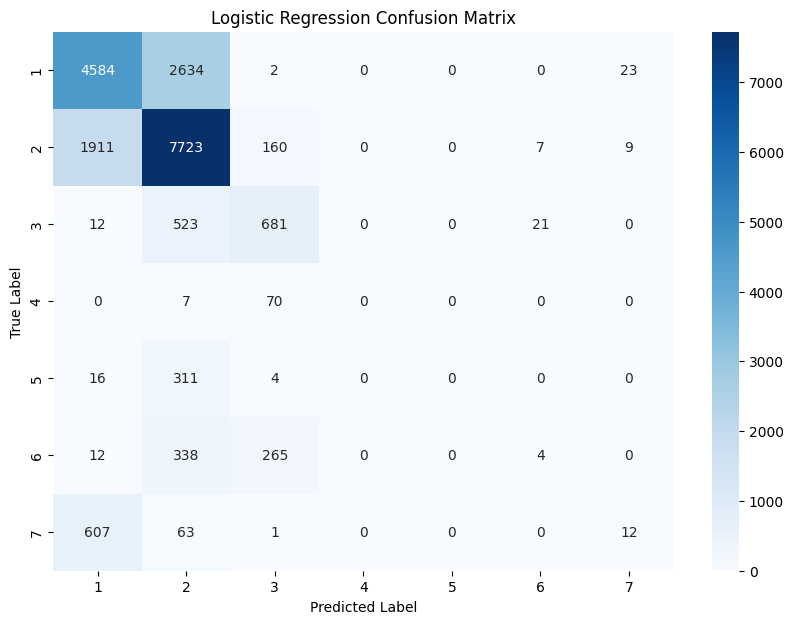

In [24]:
# Optimal hyperparameters from previous results
rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

gb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 2
}

lr_params = {
    'C': 10,
    'max_iter': 200,
    'penalty': 'l2',
    'solver': 'lbfgs'
}

# Train the models with optimal parameters
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train, y_train)

lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train)

# Generate predictions
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)

# Function to print classification report and plot confusion matrix for each model
def evaluate_model(predictions, model_name):
    print(f"{model_name} Classification Report:\n")
    report = classification_report(y_test, predictions, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report[['precision', 'recall', 'f1-score', 'support']])
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(Y), yticklabels=np.unique(Y))
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print("\n")

# Evaluate models
evaluate_model(rf_predictions, "Random Forest")
evaluate_model(gb_predictions, "Gradient Boosting")
evaluate_model(lr_predictions, "Logistic Regression")
